In [1]:
from PIL import Image, ImageFont
import string
import numpy as np
from tqdm import tqdm
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.optim as optim
from torchvision.transforms.functional import to_pil_image, to_tensor
from IPython.display import display
import wandb

import clip
from clip.model import CLIP
from utils.transform_image import (
    draw_text_with_new_lines,
    char_size,
    transform_for_resize,
)
from utils.initialize_font_data import (
    fox_text,
    fox_text_four_lines,
    gray_scale_image_file_dir,
    train_json_path,
    font_dir,
    all_gray_scale_image_file_dir,
    exclusive_attributes,
)
from utils.init_model import (
    preprocess,
    load_model,
    device,
    my_preprocess,
    preprocess_for_aug,
    preprocess_for_normalize,
)
from utils.clip_vae import VAE, VAELoss, Discriminator, AE, AELoss
from dataset.dataset import MyDataset, set_image_tensors
from models.lora_clip import LoRAConfig

exclusive_attributes:  ['capitals', 'monospace']
loading JIT archive /home/yuki/.cache/clip/ViT-B-32.pt


In [2]:
def create_image(text, font, char_size=char_size, image_file_dir=None):
    if len(text) == 1:
        width = char_size
        height = char_size
        image = draw_text_with_new_lines(text, font, width, height)
        return image
    line_num = text.count("\n") + 1
    width = int(char_size * len(text) * 0.66 / line_num)
    height = int(char_size * 1.0) * line_num
    image = draw_text_with_new_lines(text, font, width, height)
    return image


def alphabet_to_index(alphabet: str) -> int:
    if alphabet in string.ascii_uppercase:
        return ord(alphabet) - ord("A")
    if alphabet in string.ascii_lowercase:
        return ord(alphabet) - ord("a") + 26
    raise ValueError("alphabet must be in ascii_letters")


def switch_grad(nn_model: nn.Module, requires_grad: bool):
    for param in nn_model.parameters():
        param.requires_grad = requires_grad

In [3]:
# use lora model
lora_config_text = LoRAConfig(
    r=256,
    alpha=1024.0,
    bias=False,
    learnable_alpha=False,
    apply_q=True,
    apply_k=True,
    apply_v=True,
    apply_out=True,
)
signature = "cv_5_3_ViT-B_32_bce_lora_t-qkvo_256-1024.0_91011_batch64_aug250_lbound_of_scale0.35_max_attr_num_3_random_p_num_70000_geta0.2_use_negative_til1.0_lr2e-05-0.1_image_file_dir"
signature = "cv_5_0_ViT-B_32_bce_lora_t-qkvo_256-1024.0_91011_batch64_aug10_lbound_of_scale0.35_max_attr_num_3_random_p_num_100_geta0.2_use_negative_lr2e-05-0.1_image_file_dir"
signature = "cv_5_4_ViT-B_32_bce_lora_t-qkvo_256-1024.0_91011_batch64_aug250_cj_lbound_of_scale0.35_max_attr_num_3_random_p_num_70000_geta0.2_use_negative_lr2e-05-0.1_image_file_dir"
checkpoint_path = f"model_checkpoints/{signature}.pt"
lora_model = load_model(
    checkpoint_path,
    model_name="ViT-B/32",
    use_oft_vision=False,
    use_oft_text=False,
    oft_config_vision=None,
    oft_config_text=None,
    use_lora_vision=False,
    use_lora_text=True,
    lora_config_vision=None,
    lora_config_text=lora_config_text,
    use_coop_vision=False,
    use_coop_text=False,
    precontext_length_vision=None,
    precontext_length_text=None,
    precontext_dropout_rate=0.0,
    pt_applied_layers=None,
)
lora_model.eval()
for param in lora_model.parameters():
    param.requires_grad = False

loading JIT archive /home/yuki/.cache/clip/ViT-B-32.pt
init_model: loading checkpoint model_checkpoints/cv_5_4_ViT-B_32_bce_lora_t-qkvo_256-1024.0_91011_batch64_aug250_cj_lbound_of_scale0.35_max_attr_num_3_random_p_num_70000_geta0.2_use_negative_lr2e-05-0.1_image_file_dir.pt


In [4]:
generator_checkpoint_path = f'model_checkpoints/vae/{signature}.pt'
generator_checkpoint_path = None
output_ch = 1
generator = VAE(
    lora_model,
    output_ch=output_ch,
    cnn_based=True,
    mode_dual=False,
    l_relu=True,
    content_conditioned=True,
    content_dim=52,
).to(device)
if generator_checkpoint_path is not None:
    print("load vae checkpoint")
    generator.load_state_dict(torch.load(generator_checkpoint_path)["model_state_dict"])

# ae_checkpoint_path = None
# output_ch = 1
# ae = AE(
#     lora_model,
#     output_ch=output_ch,
#     input_dim=512,
#     hidden_dim=512,
#     latent_dim=128,
#     cnn_based=True,
#     mode_dual=False,
#     l_relu=True,
#     content_conditioned=True,
#     content_dim=52,
# ).to(device)
# if ae_checkpoint_path is not None:
#     print("load ae checkpoint")
#     ae.load_state_dict(torch.load(ae_checkpoint_path)["model_state_dict"])

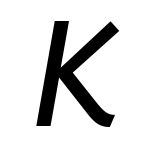

In [5]:
text = fox_text_four_lines
target_alphabet = "K"
target_alphabet_index = alphabet_to_index(target_alphabet)
font_path = "../gwfonts/ABeeZee-Italic.ttf"
font = ImageFont.truetype(font_path, char_size)
image = create_image(target_alphabet, font, char_size=char_size)
display(image)

# Define content condition, one-hot vector
condition_one_hot_vector = torch.zeros(52).to(device)
condition_one_hot_vector[target_alphabet_index] = 1

torch.Size([1, 1, 64, 64])


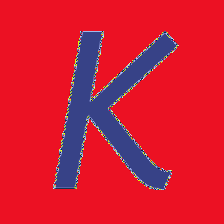

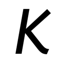

torch.Size([64, 512])
torch.Size([64, 1, 64, 64])


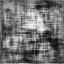

In [6]:
preprocess_for_resize_224 = transform_for_resize(224)
preprocess_for_resize_64 = transform_for_resize(64)
# auged_image = preprocess_for_aug(image)
# display(to_pil_image(auged_image))
auged_image = preprocess_for_resize_224(image)
auged_image_gray = to_tensor(to_pil_image(auged_image).convert("L"))
preprocessed_image = to_pil_image(preprocess_for_normalize(auged_image))
image_for_clip = preprocess(preprocessed_image).unsqueeze(0).to(device)
image_for_vae = (
    preprocess_for_resize_64(to_pil_image(auged_image).convert("L"))
    .unsqueeze(0)
    .to(device)
)
embedded_image = lora_model.encode_image(image_for_clip)
print(image_for_vae.shape)
display(preprocessed_image)
display(to_pil_image(image_for_vae[0].cpu()))

input = torch.stack([embedded_image.squeeze(0)] * 64, dim=0)
# content_variable = torch.stack(
#     [condition_one_hot_vector] * 64, dim=0).to(vae.dtype)
content_variable = torch.stack(
    [condition_one_hot_vector] * 64, dim=0).to(generator.dtype)
print(input.shape)
if isinstance(generator, VAE):
    x, mean, var = generator(input, content_variable=content_variable)
elif isinstance(generator, AE):
    x  = generator(input, content_variable=content_variable)
# print(x.shape, mean.shape, var.shape)
# reshape x to 224 * 224
reshaped_x = x.view(x.shape[0], 1, 64, 64)
print(reshaped_x.shape)
display(to_pil_image(reshaped_x[0]))

In [7]:
vae_target_characters = string.ascii_uppercase + string.ascii_lowercase
dataset = MyDataset(
    font_dir,
    train_json_path,
    texts_for_font_image=[fox_text_four_lines],
    use_negative=True,
    use_weight=False,
    use_score=False,
    use_multiple_attributes=True,
    use_random_attributes=True,
    random_prompts_num=100,
    max_sample_num=3,
    rich_prompt=False,
    sample_num_each_epoch=30,
    image_file_dir=all_gray_scale_image_file_dir,
    attribute_threshold=50,
    attribute_under_threshold=50,
    preprocess=preprocess,
    dump_image=True,
    exclusive_attributes=exclusive_attributes,
    geta=0.2,
    single_character=False,
    use_negative_loss=True,
    use_contrastive_image_loss=False,
    use_vae_loss=True,
    vae_target_characters=vae_target_characters,
    vae_target_characters_size=64,
    store_unnormalized_image=False,
    n_px_of_unnormalized_image=64,
    use_clip_like_format=False,
    char_size=250,
    context_length=77,
)
set_image_tensors(
    dataset,
    preprocess=my_preprocess,
    sample_num=100,
)

100%|██████████| 120/120 [00:01<00:00, 101.61it/s]


load image tensors from image files ...


100%|██████████| 120/120 [01:33<00:00,  1.28it/s]


In [8]:
data_loader = DataLoader(dataset, batch_size=208, shuffle=True)
val_data_loader = DataLoader(dataset, batch_size=208, shuffle=False)
print(len(dataset))

3600


In [9]:
generator = VAE(
    lora_model,
    output_ch=output_ch,
    cnn_based=True,
    mode_dual=False,
    l_relu=True,
    content_conditioned=True,
    content_dim=len(vae_target_characters),
).to(device)

# generator = AE(
#     lora_model,
#     output_ch=output_ch,
#     input_dim=512,
#     hidden_dim=512,
#     latent_dim=128,
#     cnn_based=True,
#     mode_dual=False,
#     l_relu=True,
#     content_conditioned=True,
#     content_dim=52,
# ).to(device)

content_discriminator = Discriminator(
    lora_model, input_ch=1, ch=64, latent_dim=256, output_dim=len(vae_target_characters)
).to(device)
auth_discriminator = Discriminator(
    lora_model, input_ch=1, ch=64, latent_dim=256, output_dim=2
).to(device)

In [10]:
def validation(generator, clip_model, images_for_display, vae_target_images_for_display, one_hot_vectors_for_display, use_cd_loss=False, use_ad_loss=False, content_discriminator=None, auth_discriminator=None):
    generator.eval()
    clip_model.eval()
    if use_cd_loss:
        assert content_discriminator is not None
        content_discriminator.eval()
    if use_ad_loss:
        assert auth_discriminator is not None
        auth_discriminator.eval()
    # print(content_discriminator.conv_in.weight[0][0][0][0])
    with torch.no_grad():
        total_loss = 0
        total_d_loss = 0
        total_ad_loss = 0
        for batch in iter(val_data_loader):
            (
                images,
                texts,
                font_indices,
                attribute_indices,
                vae_target_images,
                one_hot_vectors,
            ) = batch
            embedded_image = clip_model.encode_image(images.to(device))
            # normalization causes weird image
            # embedded_image = embedded_image / embedded_image.norm(dim=-1, keepdim=True)

            if isinstance(generator, VAE):
                x, mean, var = generator(
                    embedded_image, content_variable=one_hot_vectors.to(device)
                )
            elif isinstance(generator, AE):
                x = generator(
                    embedded_image, content_variable=one_hot_vectors.to(device)
                )
            ground_truth = vae_target_images.view(vae_target_images.shape[0], -1).to(
                device
            )
            # generator loss
            if isinstance(generator, VAE):
                loss = vae_loss(x, ground_truth, mean, var)
                total_loss += loss.item()
            elif isinstance(generator, AE):
                loss = ae_loss(x, ground_truth)
                total_loss += loss.item()

            # content discriminator loss
            if use_cd_loss:
                d_loss = ce_loss(content_discriminator(x.view(x.shape[0], 1, 64, 64).to(
                    device)), one_hot_vectors.argmax(dim=-1).to(device))
                total_d_loss += d_loss.item()

            # auth discriminator loss
            if use_ad_loss:
                prediction_x = auth_discriminator(
                    x.view(x.shape[0], 1, 64, 64).to(device))
                prediction_gt = auth_discriminator(
                    vae_target_images.to(device))
                target_x = torch.ones(
                    prediction_x.shape[0], dtype=int).to(device)
                target_gt = torch.zeros(
                    prediction_gt.shape[0], dtype=int).to(device)
                ad_loss = ce_loss(prediction_x, target_x) + \
                    ce_loss(prediction_gt, target_gt)
                total_ad_loss += ad_loss.item()

    embedded_image = clip_model.encode_image(images_for_display.to(device))
    if isinstance(generator, VAE):
        x, mean, var = generator(
            embedded_image, content_variable=one_hot_vectors_for_display.to(device)
        )
    elif isinstance(generator, AE):
        x = generator(
            embedded_image, content_variable=one_hot_vectors_for_display.to(device)
        )
    ground_truth = vae_target_images_for_display.view(vae_target_images_for_display.shape[0], -1).to(
        device
    )
    generated_image = to_pil_image(x[0].view(64, 64))
    # display(to_pil_image(ground_truth[0].view(64, 64)))
    # display(generated_image)
    total_loss /= len(val_data_loader)
    total_d_loss /= len(val_data_loader)
    total_ad_loss /= len(val_data_loader)
    generator.train()
    if use_cd_loss:
        content_discriminator.train()
    if use_ad_loss:
        auth_discriminator.train()

    return generated_image, total_loss, total_d_loss, total_ad_loss


EPOCH = 500
beta = 0.01
vae_loss = VAELoss(beta=beta, rmse=True).to(device)
ae_loss = AELoss().to(device)
ce_loss = nn.CrossEntropyLoss()
generator_lr = 1e-5
cd_lr = 1e-4
ad_lr = 1e-4
generator_optimizer = optim.Adam(
    generator.parameters(),
    lr=generator_lr,
    betas=(0.9, 0.98),
    eps=1e-6,
    weight_decay=0.2,
)
generator_schedular = optim.lr_scheduler.LinearLR(
    generator_optimizer,
    start_factor=1,
    total_iters=EPOCH * len(data_loader),
)
discriminator_optimizer = optim.Adam(
    content_discriminator.parameters(),
    lr=cd_lr,
    betas=(0.9, 0.98),
    eps=1e-6,
    weight_decay=0.2,
)
discriminator_schedular = optim.lr_scheduler.LinearLR(
    discriminator_optimizer,
    start_factor=1,
    total_iters=EPOCH * len(data_loader),
)
auth_discriminator_optimizer = optim.Adam(
    auth_discriminator.parameters(),
    lr=ad_lr,
    betas=(0.9, 0.98),
    eps=1e-6,
    weight_decay=0.2,
)
auth_discriminator_schedular = optim.lr_scheduler.LinearLR(
    auth_discriminator_optimizer,
    start_factor=1,
    total_iters=EPOCH * len(data_loader),
)

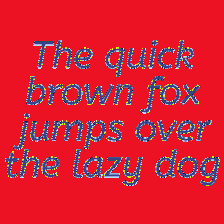

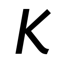

In [11]:
# prepare images for validation visualization

font_path = "../gwfonts/ABeeZee-Italic.ttf"
font_name = os.path.splitext(os.path.basename(font_path))[0]
font = ImageFont.truetype(font_path, char_size)
image_file_path = os.path.join(
    all_gray_scale_image_file_dir, font_name + ".png")
target_alphabet = "K"
image_for_clip = preprocess(Image.open(image_file_path)).unsqueeze(0)
vae_target_image = create_image(target_alphabet, font, char_size=char_size)
image_for_vae = (
    preprocess_for_resize_64(vae_target_image.convert("L"))
    .unsqueeze(0)
)

display(to_pil_image(image_for_clip[0]))
display(to_pil_image(image_for_vae[0]))

# Define content condition, one-hot vector
target_alphabet_index = alphabet_to_index(target_alphabet)
condition_one_hot_vector = torch.zeros(52)
condition_one_hot_vector[target_alphabet_index] = 1
condition_one_hot_vector = condition_one_hot_vector.unsqueeze(
    0).to(torch.float16)

In [12]:
def train(
    generator,
    images_for_display=None,
    vae_target_images_for_display=None,
    one_hot_vectors_for_display=None,
    content_discriminator=None,
    auth_discriminator=None,
    use_cd_loss=False,
    use_ad_loss=False,
    cd_loss_weight=1.0,
    ad_loss_weight=1.0,
    use_wandb=True,
    signature="vae",
    epoch=500,
):
    # torch.autograd.set_detect_anomaly(True)
    if use_wandb:
        wandb.init(
            project="FCLIP-Generator",
            entity="yukitatsu0817",
            name=signature,
            id=wandb.util.generate_id(),
        )
    if images_for_display is None:
        # prepare data for validation
        (
            images_for_display,
            _,
            _,
            _,
            vae_target_images_for_display,
            one_hot_vectors_for_display,
        ) = next(iter(val_data_loader))
    wandb.log({"reference": wandb.Image(to_pil_image(images_for_display[0]))})
    display(to_pil_image(images_for_display[0]))
    wandb.log(
        {"ground_truth": wandb.Image(to_pil_image(vae_target_images_for_display[0]))}
    )

    best_loss = None
    for epoch in tqdm(range(epoch)):
        generator.train()
        if use_cd_loss:
            assert content_discriminator is not None
            content_discriminator.train()
        if use_ad_loss:
            assert auth_discriminator is not None
            auth_discriminator.train()

        total_loss = 0
        for batch in iter(data_loader):
            (
                images,
                texts,
                font_indices,
                attribute_indices,
                vae_target_images,
                one_hot_vectors,
            ) = batch
            embedded_image = lora_model.encode_image(images.to(device))
            # normalization causes weird image
            # embedded_image = embedded_image / embedded_image.norm(dim=-1, keepdim=True)

            # train generator
            switch_grad(generator, True)
            generator_optimizer.zero_grad()
            if use_cd_loss:
                switch_grad(content_discriminator, True)
                discriminator_optimizer.zero_grad()
            if use_ad_loss:
                switch_grad(auth_discriminator, False)
                auth_discriminator_optimizer.zero_grad()

            ground_truth = vae_target_images.view(vae_target_images.shape[0], -1).to(
                device
            )
            if isinstance(generator, VAE):
                x, mean, var = generator(
                    embedded_image, content_variable=one_hot_vectors.to(device)
                )
                loss = vae_loss(x, ground_truth, mean, var)
            elif isinstance(generator, AE):
                x = generator(
                    embedded_image, content_variable=one_hot_vectors.to(device)
                )
                loss = ae_loss(x, ground_truth)
            if use_cd_loss:
                d_loss = ce_loss(
                    content_discriminator(x.view(x.shape[0], 1, 64, 64).to(device)),
                    one_hot_vectors.argmax(dim=-1).to(device),
                )
                loss += d_loss * cd_loss_weight

            if use_ad_loss:
                prediction_x = auth_discriminator(
                    x.view(x.shape[0], 1, 64, 64).to(device)
                )
                target_x = torch.zeros(prediction_x.shape[0], dtype=int).to(device)
                ad_loss = ce_loss(prediction_x, target_x)
                loss += ad_loss * ad_loss_weight
            loss.backward()
            generator_optimizer.step()
            generator_schedular.step()

            if use_cd_loss:
                discriminator_optimizer.step()
                discriminator_schedular.step()
            total_loss += loss.item()

            # train  auth_discriminator
            if use_ad_loss:
                switch_grad(generator, False)
                switch_grad(auth_discriminator, True)
                generator_optimizer.zero_grad()
                auth_discriminator_optimizer.zero_grad()
                if use_cd_loss:
                    switch_grad(content_discriminator, False)
                    discriminator_optimizer.zero_grad()

                x_detached = x.detach()
                prediction_x = auth_discriminator(
                    x_detached.view(x_detached.shape[0], 1, 64, 64).to(device)
                )
                prediction_gt = auth_discriminator(vae_target_images.to(device))
                target_x = torch.ones(prediction_x.shape[0], dtype=int).to(device)
                target_gt = torch.zeros(prediction_gt.shape[0], dtype=int).to(device)
                ad_loss = ce_loss(prediction_x, target_x) + ce_loss(
                    prediction_gt, target_gt
                )
                ad_loss.backward()
                auth_discriminator_optimizer.step()
                auth_discriminator_schedular.step()

        if epoch % 1 == 0:
            generated_image, val_loss, val_cd_loss, val_ad_loss = validation(
                generator,
                lora_model,
                images_for_display,
                vae_target_images_for_display,
                one_hot_vectors_for_display,
                content_discriminator=content_discriminator,
                auth_discriminator=auth_discriminator,
                use_ad_loss=use_ad_loss,
                use_cd_loss=use_cd_loss,
            )
            # save model
            if best_loss is None or best_loss > val_loss:
                best_loss = val_loss
                torch.save(
                    {
                        "model_state_dict": generator.state_dict(),
                        "cd_state_dict": content_discriminator.state_dict(),
                        "ad_state_dict": auth_discriminator.state_dict(),
                    },
                    f"model_checkpoints/vae/{signature}.pt",
                )
                print(f"save generator checkpoint, val_loss: {val_loss}")
            # update wandb
            if use_wandb:
                wandb.log({"loss": val_loss})
                wandb.log({"cd_loss": val_cd_loss})
                wandb.log({"ad_loss": val_ad_loss})
                wandb.log({"image": wandb.Image(generated_image)})
    if use_wandb:
        wandb.finish()

In [13]:
isinstance(generator, VAE)

True

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


vae1e-05-beta0.01


wandb: Currently logged in as: yukitatsu0817. Use `wandb login --relogin` to force relogin


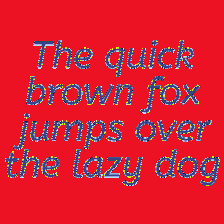

  0%|          | 1/2000 [00:05<3:01:18,  5.44s/it]

save generator checkpoint, val_loss: 0.4600287543402778


  1%|          | 20/2000 [01:45<2:55:21,  5.31s/it]

save generator checkpoint, val_loss: 0.453125


  1%|          | 21/2000 [01:51<2:55:58,  5.34s/it]

save generator checkpoint, val_loss: 0.4479573567708333


  1%|▏         | 25/2000 [02:12<2:55:02,  5.32s/it]

save generator checkpoint, val_loss: 0.4334581163194444


  1%|▏         | 26/2000 [02:17<2:55:36,  5.34s/it]

save generator checkpoint, val_loss: 0.4315456814236111


  2%|▏         | 33/2000 [02:54<2:54:31,  5.32s/it]

save generator checkpoint, val_loss: 0.4110785590277778


  2%|▏         | 40/2000 [03:31<2:54:09,  5.33s/it]

save generator checkpoint, val_loss: 0.4100206163194444


  2%|▏         | 43/2000 [03:47<2:54:51,  5.36s/it]

save generator checkpoint, val_loss: 0.3982611762152778


  2%|▏         | 44/2000 [03:53<2:55:12,  5.37s/it]

save generator checkpoint, val_loss: 0.3949110243055556


  2%|▏         | 47/2000 [04:09<2:54:18,  5.36s/it]

save generator checkpoint, val_loss: 0.3870035807291667


  3%|▎         | 51/2000 [04:30<2:53:34,  5.34s/it]

save generator checkpoint, val_loss: 0.3772379557291667


  3%|▎         | 57/2000 [05:02<2:52:48,  5.34s/it]

save generator checkpoint, val_loss: 0.3714328342013889


  3%|▎         | 65/2000 [05:44<2:51:57,  5.33s/it]

save generator checkpoint, val_loss: 0.3548041449652778


  4%|▍         | 77/2000 [06:48<2:50:50,  5.33s/it]

save generator checkpoint, val_loss: 0.349365234375


  4%|▍         | 79/2000 [06:59<2:51:25,  5.35s/it]

save generator checkpoint, val_loss: 0.3488633897569444


  5%|▍         | 94/2000 [08:19<2:50:03,  5.35s/it]

save generator checkpoint, val_loss: 0.3439398871527778


  5%|▍         | 95/2000 [08:24<2:50:40,  5.38s/it]

save generator checkpoint, val_loss: 0.3409966362847222


  5%|▍         | 96/2000 [08:30<2:51:01,  5.39s/it]

save generator checkpoint, val_loss: 0.3382839626736111


  5%|▌         | 101/2000 [08:56<2:50:24,  5.38s/it]

save generator checkpoint, val_loss: 0.3325330946180556


  5%|▌         | 106/2000 [09:23<2:49:11,  5.36s/it]

save generator checkpoint, val_loss: 0.3320990668402778


  5%|▌         | 109/2000 [09:39<2:48:50,  5.36s/it]

save generator checkpoint, val_loss: 0.3269856770833333


  6%|▌         | 114/2000 [10:06<2:47:55,  5.34s/it]

save generator checkpoint, val_loss: 0.3229573567708333


  6%|▌         | 116/2000 [10:16<2:48:12,  5.36s/it]

save generator checkpoint, val_loss: 0.3171251085069444


  7%|▋         | 147/2000 [13:01<2:44:32,  5.33s/it]

save generator checkpoint, val_loss: 0.3157552083333333


  9%|▊         | 174/2000 [15:24<2:42:26,  5.34s/it]

save generator checkpoint, val_loss: 0.3136257595486111


  9%|▉         | 175/2000 [15:29<2:43:05,  5.36s/it]

save generator checkpoint, val_loss: 0.3126898871527778


 10%|▉         | 192/2000 [17:00<2:41:27,  5.36s/it]

save generator checkpoint, val_loss: 0.3096245659722222


 12%|█▏        | 242/2000 [21:25<2:36:37,  5.35s/it]

save generator checkpoint, val_loss: 0.3085801866319444


 14%|█▍        | 290/2000 [25:40<2:32:25,  5.35s/it]

save generator checkpoint, val_loss: 0.3085123697916667


 18%|█▊        | 356/2000 [31:31<2:26:42,  5.35s/it]

save generator checkpoint, val_loss: 0.3084174262152778


 25%|██▌       | 504/2000 [44:37<2:13:25,  5.35s/it]

save generator checkpoint, val_loss: 0.3082004123263889


 31%|███       | 623/2000 [55:10<2:03:12,  5.37s/it]

save generator checkpoint, val_loss: 0.3078748914930556


 36%|███▌      | 723/2000 [1:04:02<1:53:47,  5.35s/it]

save generator checkpoint, val_loss: 0.3077935112847222


 66%|██████▌   | 1321/2000 [1:57:07<1:00:51,  5.38s/it]

save generator checkpoint, val_loss: 0.3077256944444444


 69%|██████▊   | 1371/2000 [2:01:35<55:47,  5.32s/it]  


KeyboardInterrupt: 

In [14]:
use_cd_loss = False
use_ad_loss = False
signature = ""
if isinstance(generator, VAE):
    signature += f"vae{generator_lr}-beta{beta}"
elif isinstance(generator, AE):
    signature += f"ae{generator_lr}"

if use_cd_loss:
    signature += f"_cd{cd_lr}"
if use_ad_loss:
    signature += f"_ad{ad_lr}"
print(signature)

train(
    generator=generator,
    images_for_display=image_for_clip,
    vae_target_images_for_display=image_for_vae,
    one_hot_vectors_for_display=condition_one_hot_vector,
    content_discriminator=content_discriminator,
    auth_discriminator=auth_discriminator,
    use_cd_loss=use_cd_loss,
    use_ad_loss=use_ad_loss,
    signature=signature,
    epoch=2000,
)

: 